# Machine Learning
Yorick Juffer - s1993623 \
Leon Koole - s4436563 \
... \
Alejandro Sánchez Roncero - s5279402

## Libraries

In [22]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

# new contribution
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

import seaborn as sns; sns.set()

# Loading data
This dataset contains 2000 grayscale images of handwritten digits, 200 from each class. The images are 15 × 16 
sized, making for n = 240 dimensional image vectors. The data are in the attached text file mfeat-pix.txt, 
one vector per row, sorted such that the first 200 rows are "0" digit examples, the next 200 are "1" digit examples 
etc. The grayscale encoding in mfeat-pix.txt is done by integer steps from 0 (white) to 6 (black). 

In [2]:
# Load lines from mfeat-pix.txt
features = open('mfeat-pix.txt').readlines()

# Create labels for each line, 0-9 for each 200 lines
labels = []
for i in range(10):
  for j in range(200):
    labels.append(i)
labels = np.array(labels)

# Convert each line to a numpy array
for i in range(len(features)):
  features[i] = np.array(features[i].split()).astype('float').reshape(16*15)
  # Normalize
  features[i] = features[i] / 6
features = np.array(features)

print('features: {}, labels: {}'.format(features.shape, labels.shape))

features: (2000, 240), labels: (2000,)


In [3]:
# Load augmented data
X_train_aug = np.load('X_train_augmented.npy')
X_train_aug = np.array([ff.reshape(240) for ff in X_train_aug])

X_test_aug = np.load('X_test_augmented.npy')
X_test_aug = np.array([ff.reshape(240) for ff in X_test_aug])

y_train_aug = np.array(np.load('y_train_augmented.npy'))
y_test_aug = np.array(np.load('y_test_augmented.npy'))
y_train_aug.reshape(y_train_aug.shape[0]); y_test_aug.reshape(y_test_aug.shape[0]);

## Split

In [4]:
split_train_test = 0.8

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=split_train_test, random_state=40, stratify=labels)
y_train.reshape(y_train.shape[0]); y_test.reshape(y_test.shape[0]);

In [25]:
[len(gamma_search), len(C_search), len(r_search)]

[8, 9, 5]

# SVM Model
Training of SVC and NuSVC.
- Both use one-vs-one approach
- C: by default 1 is fine. Less C means more regularization (more smooth surface), only useful for noisy observations
- Data has been scaled since they're not scale invariant
- kernel options: polynomial, rbf, sigmoid

In [26]:
# Grid search evaluation
# scores = ["precision"]
gamma_search = [1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 5e-1, 'scale', 'auto']
C_search = [1e-1, 5e-1, 1, 1.5, 2, 3, 4, 5, 10]
r_search = [0, 0.5, 1, 5, 10]
degree_search = [2, 3]

pca = PCA(n_components = 50)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

param_grid = [
    {"kernel": ["rbf"], "gamma": gamma_search, "C": C_search},
    {"kernel": ["poly"], "degree": degree_search, "coef0": r_search, "gamma": gamma_search, "C": C_search},
    {"kernel": ["sigmoid"], "coef0": r_search, "gamma": gamma_search, "C": C_search}
]

for param_dict in param_grid:
    print("Optimizing kernel: {}".format(param_dict["kernel"]))
    
    grid_search = GridSearchCV(
        svm.SVC(), 
        param_dict, 
        verbose=3,
        return_train_score=True,
        n_jobs=4
    )
    
    grid_search.fit(X_train_reduced, y_train)
    best_score_on_test = grid_search.score(X_test_reduced, y_test)

    print("params: {} with mean test score: {}".format(grid_search.best_params_, grid_search.best_score_))

    grid_search_df = pd.DataFrame(grid_search.cv_results_)
    grid_search_df.to_csv("SVM/grid_search_{}.csv".format(param_dict["kernel"][0]))

Optimizing kernel: ['rbf']
Fitting 5 folds for each of 72 candidates, totalling 360 fits
params: {'C': 2, 'gamma': 0.05, 'kernel': 'rbf'} with mean test score: 0.983125
Optimizing kernel: ['poly']
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
params: {'C': 0.1, 'coef0': 0.5, 'degree': 2, 'gamma': 0.5, 'kernel': 'poly'} with mean test score: 0.9862500000000001
Optimizing kernel: ['sigmoid']
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
params: {'C': 10, 'coef0': 0, 'gamma': 0.01, 'kernel': 'sigmoid'} with mean test score: 0.971875


In [37]:
# Training of the rbf-based kernel
pca_aug = PCA(n_components = 50)
pca_aug.fit(X_train_aug)
X_train_aug_reduced = pca_aug.transform(X_train_aug)
X_test_aug_reduced = pca_aug.transform(X_test_aug)
    
svc_rbf = svm.SVC(decision_function_shape='ovo', C=2, gamma=0.05, kernel="rbf", probability=True) 
svc_rbf.fit(X_train_reduced, y_train)

svc_rbf_aug = svm.SVC(decision_function_shape='ovo', C=2, gamma=0.05, kernel="rbf", probability=True) 
svc_rbf_aug.fit(X_train_aug_reduced, y_train_aug)

# Training of the polynomial-based kernel
svc_poly = svm.SVC(decision_function_shape='ovo', C=0.1, coef0=0.5, degree=2, gamma=0.5, kernel="poly", probability=True) 
svc_poly.fit(X_train_reduced, y_train)

svc_poly_aug = svm.SVC(decision_function_shape='ovo', C=0.1, coef0=0.5, degree=2, gamma=0.5, kernel="poly", probability=True) 
svc_poly_aug.fit(X_train_aug_reduced, y_train_aug)

# Training of the polynomial-based kernel
svc_sig = svm.SVC(decision_function_shape='ovo', C=10, coef0=0.0, gamma=0.01, kernel="poly", probability=True) 
svc_sig.fit(X_train_reduced, y_train)

svc_sig_aug = svm.SVC(decision_function_shape='ovo', C=10, coef0=0.0, gamma=0.01, kernel="poly", probability=True) 
svc_sig_aug.fit(X_train_aug_reduced, y_train_aug)

SVC(C=10, decision_function_shape='ovo', gamma=0.01, kernel='poly',
    probability=True)

In [43]:

df_support_vectors = pd.DataFrame(np.vstack((svc_rbf.n_support_ / 160, svc_rbf_aug.n_support_ / 1000,
                        svc_poly.n_support_ / 160, svc_poly_aug.n_support_ / 1000,
                        svc_sig.n_support_ /160, svc_sig_aug.n_support_ / 1000)))
df_support_vectors.to_csv("SVM/support_vectors.csv")


## Model evaluation -> average across several splits of the dataset

In [69]:
random_seeds = [0, 21, 42, 100, 200, 300, 400, 500, 700, 1000]
scores_rbf = []; scores_rbf_d = []; scores_poly = []; scores_sigma = []
for rs in random_seeds:

    split_train_test = 0.2

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=split_train_test, random_state=rs, stratify=labels)
    y_train.reshape(y_train.shape[0]); y_test.reshape(y_test.shape[0])

    pca = PCA(n_components = 50)
    pca.fit(X_train)
    X_train_reduced = pca.transform(X_train)
    X_test_reduced = pca.transform(X_test)
    
    svc_rbf = svm.SVC(decision_function_shape='ovo', C=2, gamma=0.05, kernel="rbf", probability=True) 
    svc_rbf.fit(X_train_reduced, y_train)
    scores_rbf.append(svc_rbf.score(X_test_reduced, y_test))
    
    svc_rbf_d = svm.SVC(decision_function_shape='ovo', kernel="rbf", probability=True) 
    svc_rbf_d.fit(X_train_reduced, y_train)
    scores_rbf_d.append(svc_rbf_d.score(X_test_reduced, y_test))
    
    svc_poly = svm.SVC(decision_function_shape='ovo', C=0.1, coef0=0.5, degree=2, gamma=0.5, kernel="poly", probability=True) 
    svc_poly.fit(X_train_reduced, y_train)  
    scores_poly.append(svc_poly.score(X_test_reduced, y_test))
    
    svc_sig = svm.SVC(decision_function_shape='ovo', C=10, coef0=0.0, gamma=0.01, kernel="poly", probability=True) 
    svc_sig.fit(X_train_reduced, y_train)
    scores_sigma.append(svc_sig.score(X_test_reduced, y_test))

print("RBF, RBFD, POLY, SIGGMA: {:.4f}, {:.4f}, {:.4f}, {:.4f}".format(np.mean(scores_rbf), np.mean(scores_rbf_d), np.mean(scores_poly), np.mean(scores_sigma)))

print(classification_report(y_test, svc_rbf.predict(X_test_reduced), target_names=["{}".format(ii) for ii in range(10)], digits=4))



RBF, RBFD, POLY, SIGGMA: 0.9795, 0.9775, 0.9773, 0.9710
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        40
           1     0.9512    0.9750    0.9630        40
           2     0.9750    0.9750    0.9750        40
           3     1.0000    1.0000    1.0000        40
           4     1.0000    1.0000    1.0000        40
           5     0.9756    1.0000    0.9877        40
           6     1.0000    1.0000    1.0000        40
           7     1.0000    0.9750    0.9873        40
           8     1.0000    0.9750    0.9873        40
           9     0.9500    0.9500    0.9500        40

    accuracy                         0.9850       400
   macro avg     0.9852    0.9850    0.9850       400
weighted avg     0.9852    0.9850    0.9850       400



In [68]:
svc_rbf.score(X_test_reduced, y_test, )

0.985

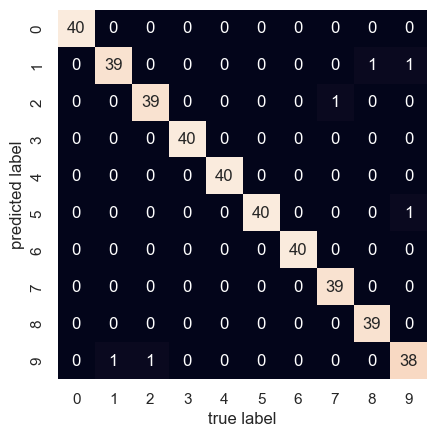

In [66]:
mat = confusion_matrix(y_test, svc_rbf.predict(X_test_reduced))
digits_names = ["{}".format(ii) for ii in range(10)]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits_names, yticklabels=digits_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('SVM/confusion_matrix_svm_original.png')

In [51]:
random_seeds = [0, 21, 42, 100, 200, 300, 400, 500, 700, 1000]
scores_rbf = []

pca_aug = PCA(n_components = 50)
pca_aug.fit(X_train_aug)
X_train_aug_reduced = pca_aug.transform(X_train_aug)
X_test_aug_reduced = pca_aug.transform(X_test_aug)

for rs in random_seeds:
    
    svc_rbf_aug = svm.SVC(decision_function_shape='ovo', C=2, gamma=0.05, kernel="rbf", probability=True) 
    svc_rbf_aug.fit(X_train_aug_reduced, y_train_aug)

    scores_rbf.append(svc_rbf_aug.score(X_test_aug_reduced, y_test_aug))

print("RBF: {:.3f}".format(np.mean(scores_rbf)))


cprint(lassification_report(y_test_aug, svc_rbf_aug.predict(X_test_aug_reduced), target_names=["{}".format(ii) for ii in range(10)]))

RBF: 0.983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.97      0.99        40
           2       1.00      1.00      1.00        40
           3       0.91      0.97      0.94        40
           4       0.98      1.00      0.99        40
           5       0.95      0.93      0.94        40
           6       1.00      0.95      0.97        40
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



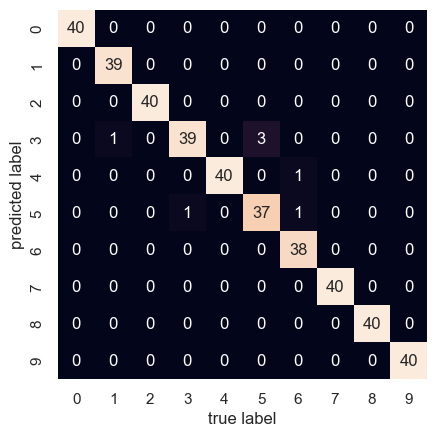

In [53]:
mat = confusion_matrix(y_test_aug, svc_rbf_aug.predict(X_test_aug_reduced))
digits_names = ["{}".format(ii) for ii in range(10)]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits_names, yticklabels=digits_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('SVM/confusion_matrix_svm_augmented.png')

In [17]:
n_cases = 20
pred = svc_poly_aug.predict(X_test_aug_reduced[0:n_cases])
probs = svc_poly_aug.predict_proba(X_test_aug_reduced[0:n_cases])
labs = y_test_aug[0:n_cases]

for ii in range(n_cases):
    print("Digit: {} with prob: {} ({}, {}) - Original: {}".format(pred[ii], probs[ii][pred[ii]], min(probs[ii]), max(probs[ii]), labs[ii]))

Digit: 9 with prob: 0.9985855606667047 (1.1596074508702128e-05, 0.9985855606667047) - Original: 9
Digit: 2 with prob: 0.9999171190285532 (1.0258202018095186e-08, 0.9999171190285532) - Original: 2
Digit: 0 with prob: 0.998949335642712 (1.8239353290804458e-05, 0.998949335642712) - Original: 0
Digit: 6 with prob: 0.9999109128168908 (8.61471237486617e-08, 0.9999109128168908) - Original: 6
Digit: 1 with prob: 0.9990747751039938 (8.598787748839722e-08, 0.9990747751039938) - Original: 1
Digit: 8 with prob: 0.9999654468472761 (3.639512285398628e-08, 0.9999654468472761) - Original: 8
Digit: 4 with prob: 0.9999024583814561 (2.3693887248628582e-09, 0.9999024583814561) - Original: 4
Digit: 0 with prob: 0.9996351255544711 (1.0453548146059121e-05, 0.9996351255544711) - Original: 0
Digit: 2 with prob: 0.9989564564497914 (7.096139004868389e-06, 0.9989564564497914) - Original: 2
Digit: 1 with prob: 0.9997636467417043 (3.352868506378932e-08, 0.9997636467417043) - Original: 1
Digit: 5 with prob: 0.997187